In [ ]:
import os
import subprocess
from pathlib import Path

import h5py
import datamate.io        # Where the function is defined
import datamate.directory # Where the function is actually CALLED causing the error

In [ ]:
data_path = Path("data/flyvis_data")
data_path.mkdir(parents=True, exist_ok=True)

env = os.environ.copy()
env["FLYVIS_ROOT_DIR"] = str(data_path)

In [ ]:
def download_flyvis_data():
    print(f"Starting download to: {data_path}...")
    try:
        subprocess.run(["flyvis", "download-pretrained"], env=env, check=True, shell=True)
        print("\nDownload complete!")
    except subprocess.CalledProcessError as e:
        print(f"\nError during download: {e}")

# download_flyvis_data()

## Exploration

#### Windows workaround - loading the network

In [9]:
def fixed_write_h5(path, val):
    """
    A Windows-safe replacement that skips the 'read-before-write' check.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    # Simple, safe write. No checking 'f["data"]', no 'unlink'.
    # This completely bypasses the logic causing your KeyError.
    with h5py.File(path, mode="w", libver="latest") as f:
        f.create_dataset("data", data=val)

# --- STEP 2: APPLY THE PATCH EVERYWHERE ---
print("Applying aggressive patches...")

# Patch 1: The definition
datamate.io._write_h5 = fixed_write_h5

# Patch 2: The copy inside directory.py (THIS IS THE KEY FIX)
# This forces the Directory class to use OUR function, not the old one it imported.
if hasattr(datamate.directory, "_write_h5"):
    datamate.directory._write_h5 = fixed_write_h5
    print(" -> Patched datamate.directory._write_h5")
else:
    print(" -> Warning: Could not find _write_h5 in directory module")


print("Importing flyvis...")
from flyvis import NetworkView

Applying aggressive patches...
 -> Patched datamate.directory._write_h5
Importing flyvis...


In [10]:
network_view = NetworkView("flow/0000/000")
print("SUCCESS: Network loaded.")

[2026-01-05 20:07:38] network_view:122 Initialized network view at C:\Users\dean\Documents\dev\fly_winter_school\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000


SUCCESS: Network loaded.


#### Network exploration

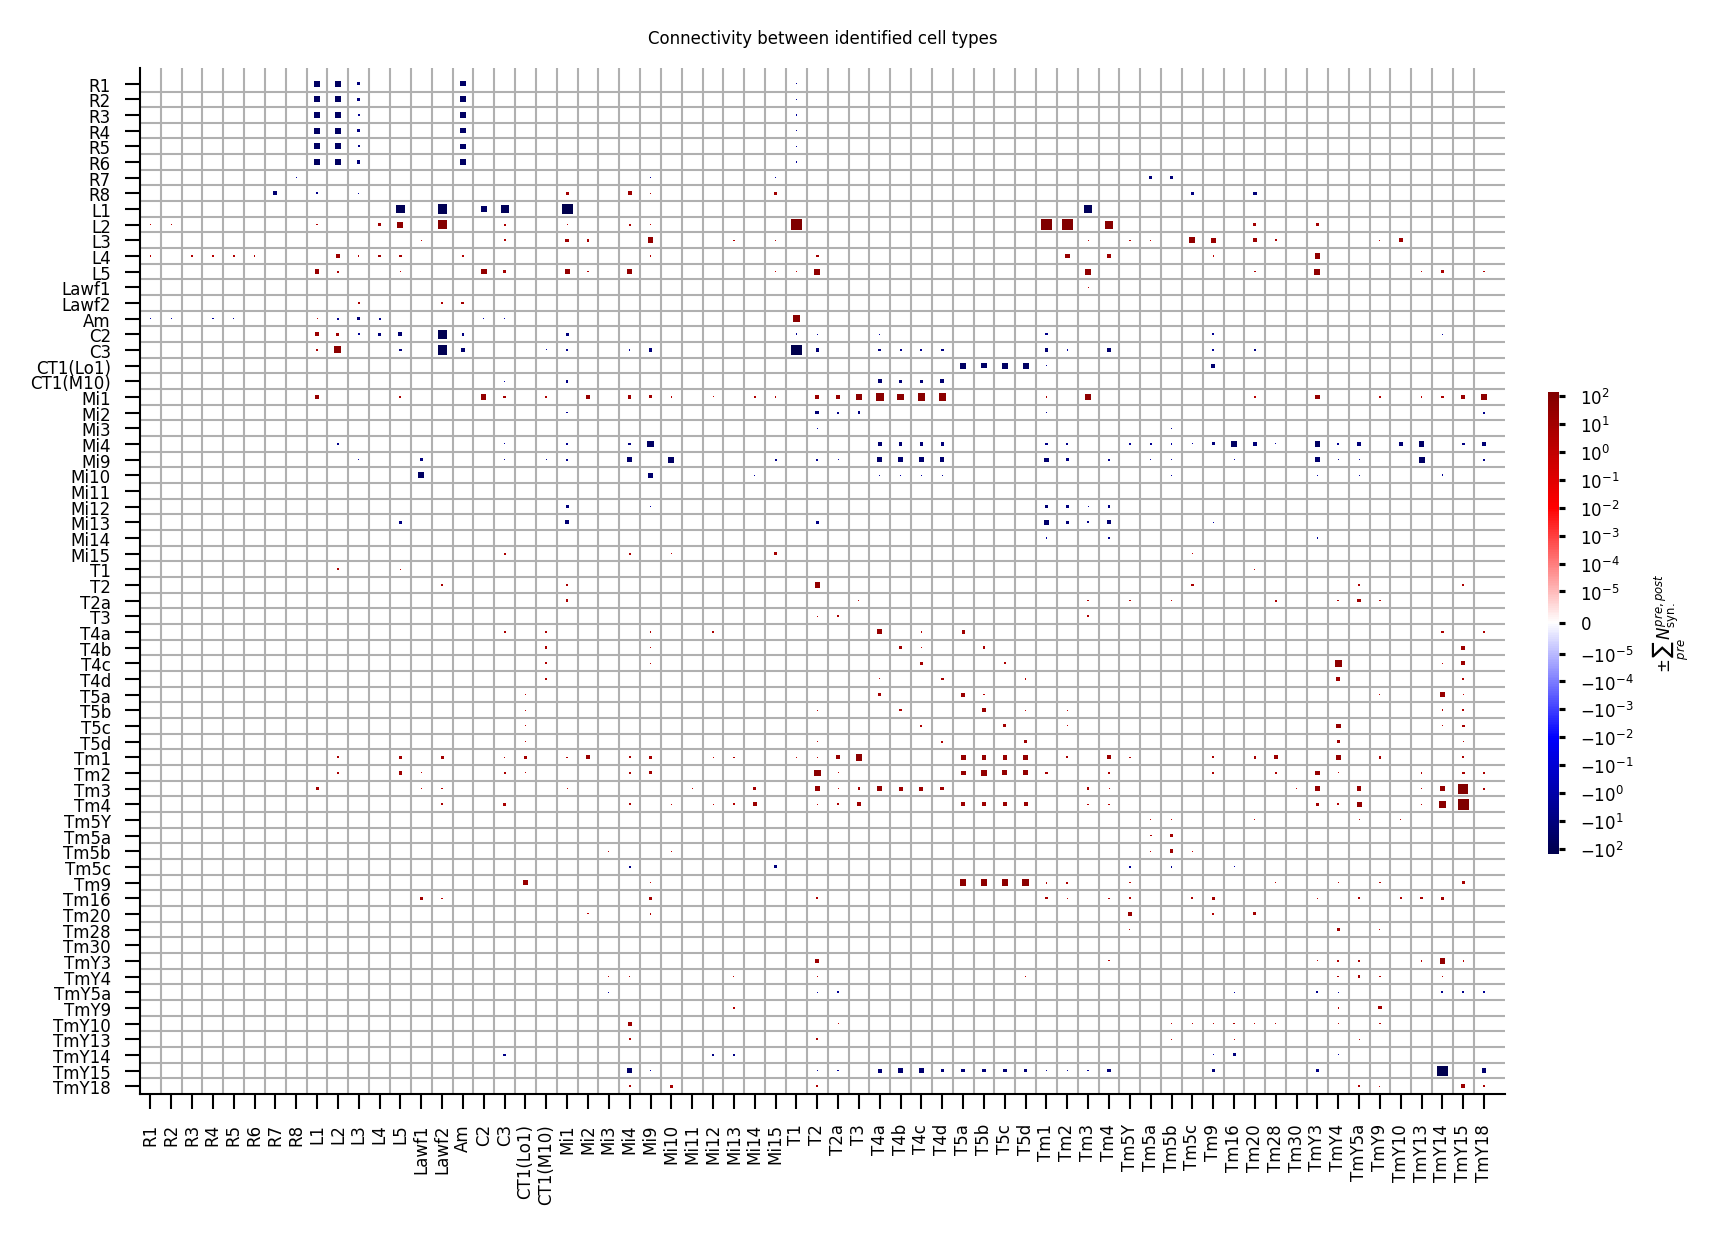

In [11]:
fig = network_view.connectivity_matrix()

In [12]:
connectome = network_view.connectome
synapse_df = connectome.edges.to_df()
print(f'✓ Extracted {len(synapse_df):,} synapses from FlyVis connectome')
# synapse_df.to_csv(f'{data_path}/flyvis_full_synapse_df.csv', index=False)
synapse_df.head()

✓ Extracted 1,513,231 synapses from FlyVis connectome


,du,dv,n_syn,n_syn_certainty,sign,source_index,source_type,source_u,source_v,target_index,target_type,target_u,target_v
0,0,0,40.0,5.859477,-1.0,0,R1,-15,0,5768,L1,-15,0
1,0,0,40.0,5.859477,-1.0,1,R1,-15,1,5769,L1,-15,1
2,0,0,40.0,5.859477,-1.0,2,R1,-15,2,5770,L1,-15,2
3,0,0,40.0,5.859477,-1.0,3,R1,-15,3,5771,L1,-15,3
4,0,0,40.0,5.859477,-1.0,4,R1,-15,4,5772,L1,-15,4


In [13]:
cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')
print(cell_type_df.shape)
cell_type_df.head()

(604, 3)


,source_type,target_type,syn_count
0,Am,C2,721
1,Am,C3,721
2,Am,L1,721
3,Am,L2,721
4,Am,L3,721


In [14]:
# cell_type_df.to_csv('data/flyvis_data/flyvis_cell_type_connectivity.csv', index=False)

In [15]:
cell_type_df[cell_type_df.source_type == 'C2']

,source_type,target_type,syn_count
11,C2,Am,721
12,C2,L1,721
13,C2,L2,721
14,C2,L3,721
15,C2,L4,1380
16,C2,L5,721
17,C2,Lawf2,2143
18,C2,Mi1,721
19,C2,T1,721
20,C2,T2,690


In [16]:
c2 = synapse_df[synapse_df['source_type'] == 'C2']
c2[c2['target_type'] == 'L4']

,du,dv,n_syn,n_syn_certainty,sign,source_index,source_type,source_u,source_v,target_index,target_type,target_u,target_v
179158,0,1,6.444445,4.824132,-1.0,10340,C2,-15,0,7932,L4,-15,1
179159,0,1,6.444445,4.824132,-1.0,10341,C2,-15,1,7933,L4,-15,2
179160,0,1,6.444445,4.824132,-1.0,10342,C2,-15,2,7934,L4,-15,3
179161,0,1,6.444445,4.824132,-1.0,10343,C2,-15,3,7935,L4,-15,4
179162,0,1,6.444445,4.824132,-1.0,10344,C2,-15,4,7936,L4,-15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180533,-1,1,5.666667,4.824132,-1.0,11056,C2,15,-4,8631,L4,14,-3
180534,-1,1,5.666667,4.824132,-1.0,11057,C2,15,-3,8632,L4,14,-2
180535,-1,1,5.666667,4.824132,-1.0,11058,C2,15,-2,8633,L4,14,-1
180536,-1,1,5.666667,4.824132,-1.0,11059,C2,15,-1,8634,L4,14,0


#### Network Override exploration

In [17]:
network = network_view.init_network()

[2026-01-05 20:07:40] logging_utils:23 epe not in C:\Users\dean\Documents\dev\fly_winter_school\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000\validation, but 'loss' is. Falling back to 'loss'. You can rerun the ensemble validation to make appropriate recordings of the losses.
[2026-01-05 20:07:43] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-05 20:07:43] chkpt_utils:36 Recovered network state.


In [18]:
cell_type_df[cell_type_df.source_type == 'C2']

,source_type,target_type,syn_count
11,C2,Am,721
12,C2,L1,721
13,C2,L2,721
14,C2,L3,721
15,C2,L4,1380
16,C2,L5,721
17,C2,Lawf2,2143
18,C2,Mi1,721
19,C2,T1,721
20,C2,T2,690


In [19]:
network.edge_params.syn_count.raw_values

Parameter containing:
tensor([3.6889, 3.8286, 2.3979,  ..., 0.0000, 0.2877, 0.0000])

In [20]:

print(len(network.edge_params.syn_strength.keys))
print(network.edge_params.syn_strength.raw_values.shape)

syn_str = network.edge_params.syn_strength.keys
idx = 0
for idx, (src, tar) in enumerate(syn_str):
    if src == 'C2' and tar == 'L4':
        print(f'Found syn strength for C2 -> L4 in index;', idx)
        print('syn str:',network.edge_params.syn_strength.raw_values[idx])
        # network.edge_params.syn_strength.raw_values.detach()[idx] = 0 # perturb it


604
torch.Size([604])
Found syn strength for C2 -> L4 in index; 135
syn str: tensor(0.0405, grad_fn=<SelectBackward0>)


#### Columns - exploration

In [21]:
from flyvis import connectome_file
from flyvis import ConnectomeFromAvgFilters, ConnectomeView

config = dict(file=connectome_file.name, extent=1, n_syn_fill=1)
connectome = ConnectomeFromAvgFilters(config)

In [22]:
node_df = connectome.nodes.to_df()
# node_df.to_csv(f'{my_data_path}/e1_nodes.csv', index=False)

In [23]:
node_df.head()

,index,role,type,u,v
0,0,input,R1,-1,0
1,1,input,R1,-1,1
2,2,input,R1,0,-1
3,3,input,R1,0,0
4,4,input,R1,0,1


In [24]:
synapse_df = connectome.edges.to_df()
print(f'✓ Extracted {len(synapse_df):,} synapses from FlyVis connectome')
# synapse_df.to_csv(f'{data_path}/e1_synapses.csv', index=False)
synapse_df.head()

✓ Extracted 8,174 synapses from FlyVis connectome


,du,dv,n_syn,n_syn_certainty,sign,source_index,source_type,source_u,source_v,target_index,target_type,target_u,target_v
0,0,0,40.0,5.859477,-1.0,0,R1,-1,0,56,L1,-1,0
1,0,0,40.0,5.859477,-1.0,1,R1,-1,1,57,L1,-1,1
2,0,0,40.0,5.859477,-1.0,2,R1,0,-1,58,L1,0,-1
3,0,0,40.0,5.859477,-1.0,3,R1,0,0,59,L1,0,0
4,0,0,40.0,5.859477,-1.0,4,R1,0,1,60,L1,0,1


#### Override the h5 - exploration

In [25]:
filename = "data/flyvis_data/connectome/ConnectomeFromAvgFilters_0006/edges/n_syn.h5"

In [26]:
# pert; reset the n_syn inside the h5
connectome.edges.n_syn

--- Inspection of 'data' ---
First 10 values: [40. 40. 40. 40. 40. 40. 40. 46. 46. 46.]
Last 10 values:  [1.3333334 1.3333334 1.3333334 1.        1.        1.        1.
 1.        1.        1.       ]

--- Statistics ---
Min:  0.0447
Max:  144.0909
Mean: 4.8259
Std:  11.3766


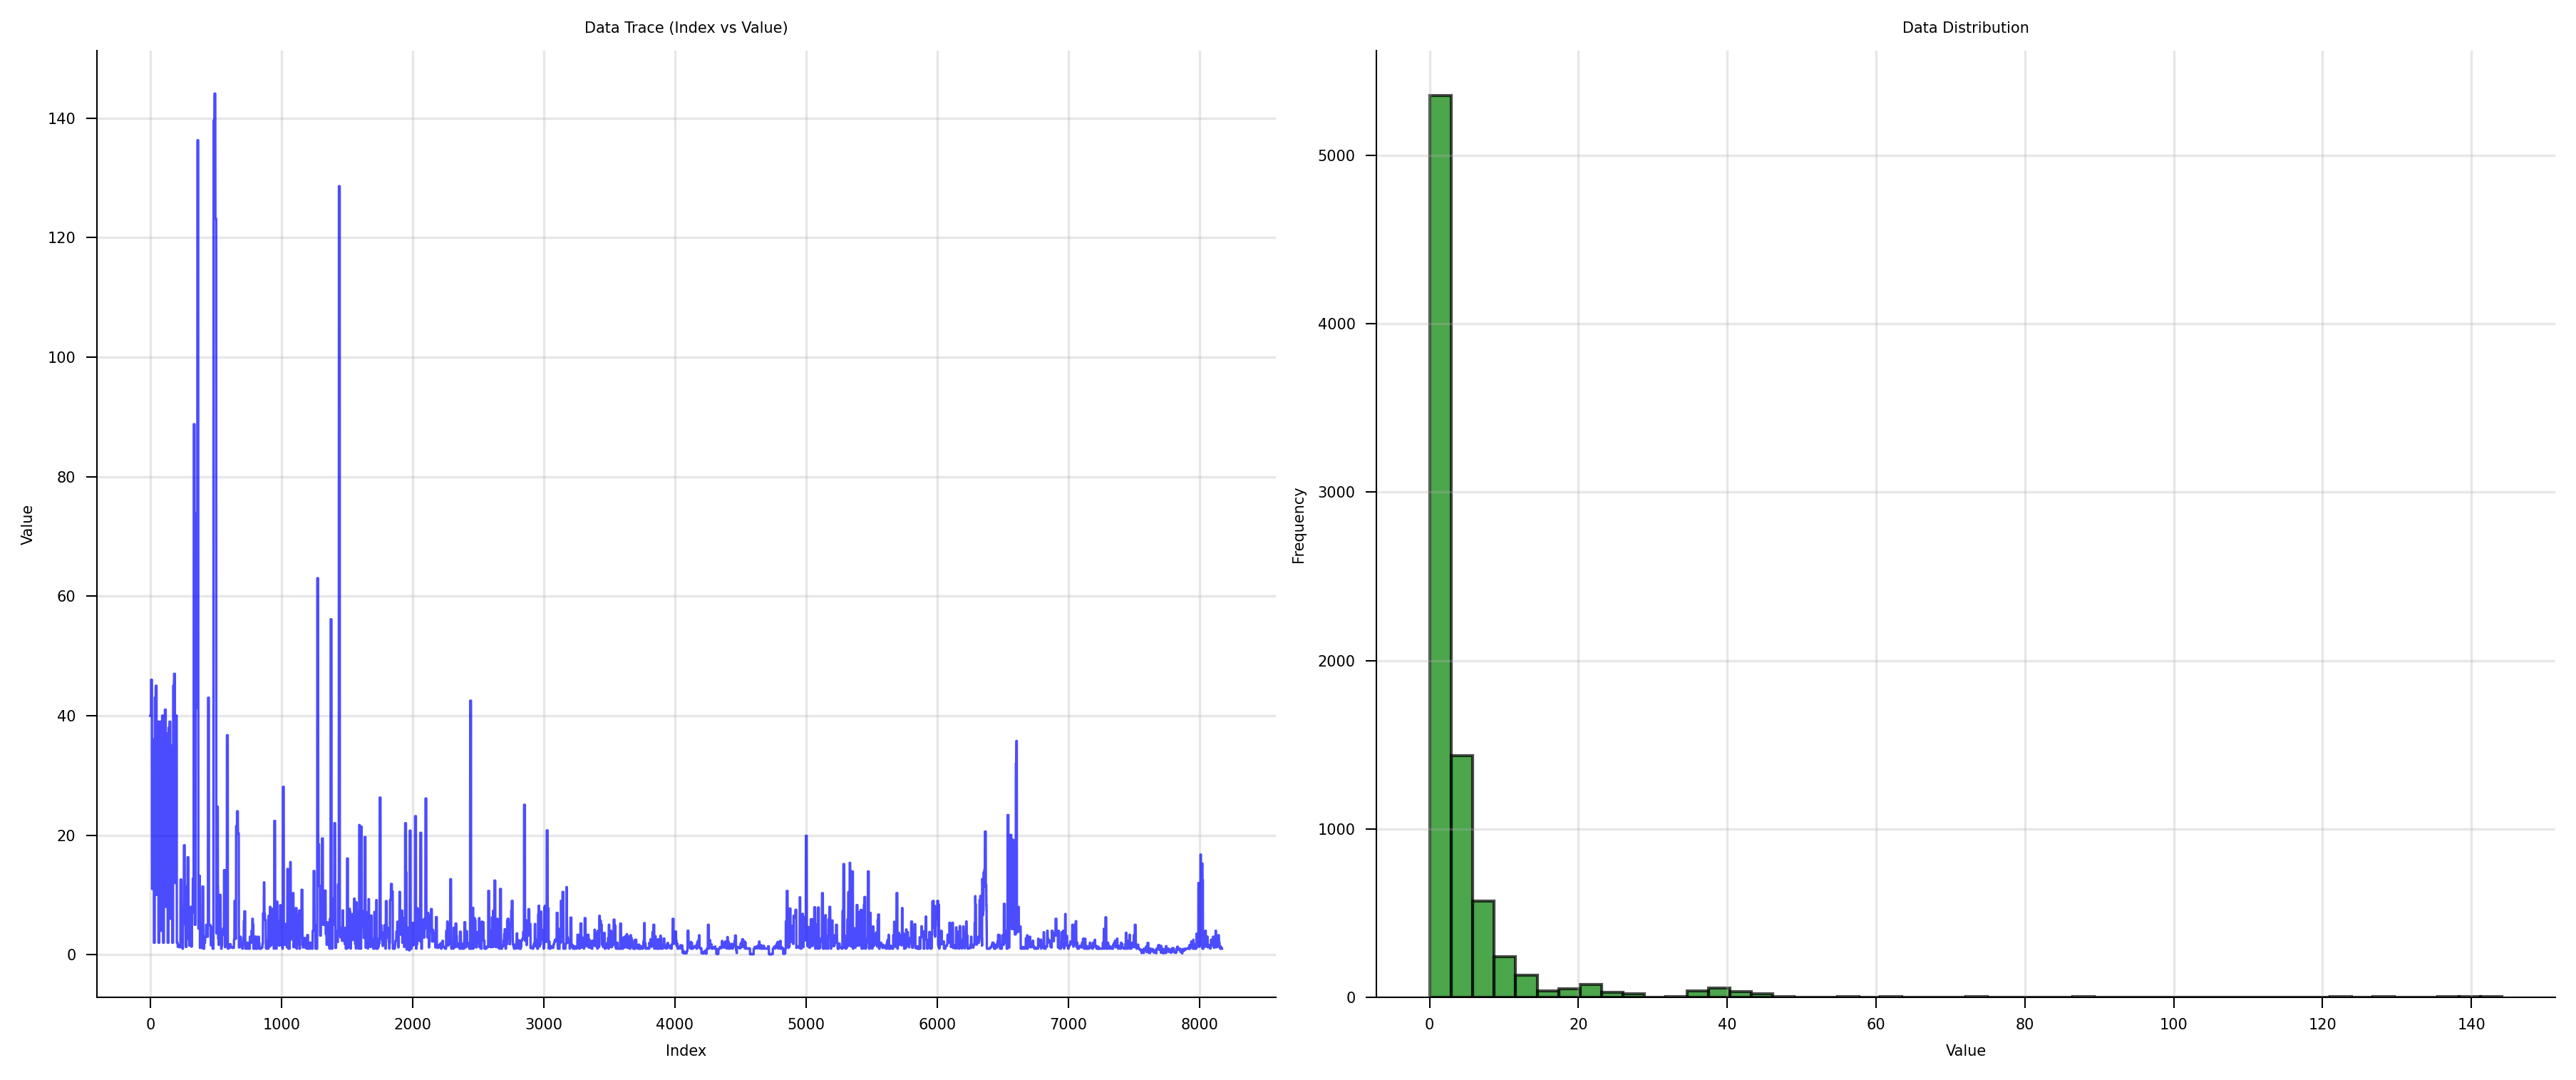

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


# filename = connectome.edges.n_syn


with h5py.File(filename, 'r') as f:
    # 1. Load the data into memory
    # We use [:] to copy the HDF5 dataset into a NumPy array
    data = f['data'][:]

    print(f"--- Inspection of 'data' ---")
    
    # 2. View Raw Values
    print(f"First 10 values: {data[:10]}")
    print(f"Last 10 values:  {data[-10:]}")
    
    # 3. Basic Statistics
    print(f"\n--- Statistics ---")
    print(f"Min:  {np.min(data):.4f}")
    print(f"Max:  {np.max(data):.4f}")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Std:  {np.std(data):.4f}")
    
    # 4. Visualization
    # Create a figure with two subplots: a Line Plot and a Histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot A: The Trace (Index vs Value)
    ax1.plot(data, color='blue', alpha=0.7, linewidth=0.8)
    ax1.set_title("Data Trace (Index vs Value)")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")
    ax1.grid(True, alpha=0.3)

    # Plot B: The Distribution (Histogram)
    ax2.hist(data, bins=50, color='green', alpha=0.7, edgecolor='black')
    ax2.set_title("Data Distribution")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Example

In [28]:
import copy
import torch

In [29]:
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType
pert = FlyvisCellTypePert()

In [30]:
original_network = network_view.init_network()
perturbed_network = copy.deepcopy(original_network)

[2026-01-05 20:07:43] chkpt_utils:36 Recovered network state.


In [31]:
pairs_to_perturb = [('Am', 'L3')]
pert_conn = pert.perturb(conn=cell_type_df,
                        perturbation_type=PerturbationType.PAIR_WISE,
                        pairs=pairs_to_perturb)

In [32]:
# validate the pert_weight is 0
pert_conn[pert_conn.pert_weight == 0]

,source_type,target_type,syn_count,pert_weight
4,Am,L3,721,0


In [33]:
# override the network weights

In [34]:
def get_pair_index_in_network(perturbed_network, source_type, target_type):
    syn_str = perturbed_network.edge_params.syn_strength.keys
    for idx, (src, tar) in enumerate(syn_str):
        if src == source_type and tar == target_type:
            return idx
    return None

In [35]:
idx = get_pair_index_in_network(perturbed_network, 'Am', 'L3')
print('Am -> L3 index:', idx)
weight_before = perturbed_network.edge_params.syn_strength.raw_values[idx]
print('Weight before perturbation:', weight_before)

Am -> L3 index: 127
Weight before perturbation: tensor(0.0402, grad_fn=<SelectBackward0>)


In [36]:
pert.override_network(perturbed_network, pert_conn)
weight_after = perturbed_network.edge_params.syn_strength.raw_values[idx]
print('Weight after perturbation:', weight_after)

Weight after perturbation: tensor(0., grad_fn=<SelectBackward0>)


In [ ]:
orig_weights = original_network.edge_params.syn_strength.raw_values
pert_weights = perturbed_network.edge_params.syn_strength.raw_values

# Find differences
weight_diff = (pert_weights - orig_weights).abs()
changed_mask = weight_diff > 1e-8
changed_indices = torch.where(changed_mask)[0]

print(f"Number of connections changed: {len(changed_indices)}")

if len(changed_indices) > 0:
    syn_keys = original_network.edge_params.syn_strength.keys
    print("\nChanged connections:")
    for idx in changed_indices:
        src, tar = syn_keys[idx]
        print(f"  {src} -> {tar}: {orig_weights[idx].item():.4f} → {pert_weights[idx].item():.4f}")
else:
    print("Perturbed network is identical to original network.")

Number of connections changed: 1

Changed connections:
  Am -> L3: 0.0402 → 0.0000
